# Assignment 6 
## Import the data 
As seen before we can easielly import the data using built in dataset commands.  From what was in the previous assignment, MNIST is a list of 60000 handwritten images of handwritten numbers made of 28x28 images. Upon importing we can divide the datasets directly.  In order for my computer to process the data in decent time, we should thin out both datasets.  

In [1]:
from tensorflow import keras
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
X_valid = X_train[:5000]/255.
X_train = X_train[5000:]/255.
X_test = X_test/255.
y_valid = y_train[:5000]
y_train = y_train[5000:]


2025-07-29 18:31:13.957563: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


We are also going to want to scale the digits between 0 and 1.  


X_train = X_train/255.
X_valid = X_valid/255. 
X_test = X_test / 255.

As means for validation of a successful import, lets have a look at an image. 

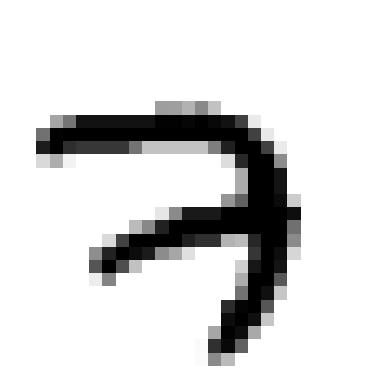

In [2]:
import matplotlib.pyplot as plt
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

The data agrees with my eyes, that's a 5.  With any luck we will get the same eyes with our  model. 

In [3]:
y_train[0]

7

# Building our Network
We should start by evaluating the learning rate.  Using a gsd we will determin the proper parameter for the dataset. The object below includes two arrays: rates and losses.  A low learning rate will cause us to not pick up proper 'rules' for determining which digit is which - a high learning rate is a sure way to create overfit.  Losses are the gradieants in which the backpropaged weights are updated. Finally, the object is included with the Keras.backend.set_value.  

In [4]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.learning_rate, self.model.optimizer.learning_rate * self.factor)

In [5]:
import numpy as np
import tensorflow as tf
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

The model includes 4 different layers.  The first layer flatten is a input is a reshaping layer, this flattens the inputs.  The other three are Dense layers are dense layers, they are core layers that computes the transoformation between the 
kernal and the input.  The arguments used are units, which determines the outputs(or nurons); our final layer needs to have 10 units (one per each number) 
and dense included are two layers of relu and one layer of softmax.  

In [6]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

/opt/anaconda3/lib/python3.9/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Here we compile the modle and calculate the crossentrophy loss.  Using a learning rate of.001 we are looking for the most accurate model.  

In [7]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])
expon_lr = ExponentialLearningRate(factor=1.005)

Using the object for Exponential Learning (1.005) we can look at or fist model for analysis. 

In [21]:
#history = model.fit(X_train, y_train, epochs=1,
#                    validation_data=(X_valid, y_valid),
#                    callbacks=[expon_lr])

As you can see from the model, the data seems to spike at about 1.  Hence the gradiance is greater than the loss.  

/var/folders/3r/pc8xl1ls1y35f9xzjdj87z0c0000gn/T/ipykernel_35715/2891158959.py:4: UserWarning: Attempting to set identical left == right == 0.0010000000474974513 results in singular transformations; automatically expanding.
  plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])


Text(0, 0.5, 'Loss')

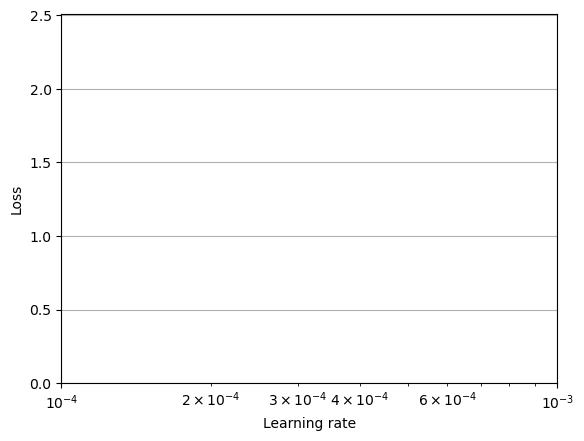

In [12]:
plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale('log')
plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates))
plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])
plt.grid()
plt.xlabel("Learning rate")
plt.ylabel("Loss")

Now we go through te process of creating and compiling the same model as above, however, we are looking at a learning rate of .1.  

In [13]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [14]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [15]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=.1),
              metrics=["accuracy"])

In [16]:
import os
run_index = 1 # increment this at every run
run_logdir = os.path.join(os.curdir, "my_mnist_logs", "run_{:03d}".format(run_index))
run_logdir

'./my_mnist_logs/run_001'

Finally, we create a model using 100 (I mean 30!) epochs. Because we set the patients to 20, we 'quit early' to avoid overfitting and unnecessary processing.  

In [20]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
#checkpoint_cb = keras.callbacks.ModelCheckpoint("my_mnist_model.h5", save_best_only=True)
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_mnist_model.keras", save_best_only=True)
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

Epoch 1/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8590 - loss: 0.4621 - val_accuracy: 0.9634 - val_loss: 0.1244
Epoch 2/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9635 - loss: 0.1218 - val_accuracy: 0.9742 - val_loss: 0.0920
Epoch 3/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9770 - loss: 0.0777 - val_accuracy: 0.9746 - val_loss: 0.0815
Epoch 4/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9845 - loss: 0.0540 - val_accuracy: 0.9762 - val_loss: 0.0782
Epoch 5/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9895 - loss: 0.0385 - val_accuracy: 0.9772 - val_loss: 0.0755
Epoch 6/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9933 - loss: 0.0271 - val_accuracy: 0.9784 - val_loss: 0.0728
Epoch 7/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9962 - loss: 0.0189 - val_accuracy: 0.9788 - val_loss: 0.0757
Epoch 8/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9975 - loss: 0

# Model evaluations 
It looks like we made our goal of 98%!  However, more impressibly the loss was only .06.  This is likely due to the relatively high learning rate that stayed below 1.  A low loss rate is in many cases a better way of demonstrating how a model is better (assuming it's not due to overfitting) than accuaracy.  

In [24]:
model = keras.models.load_model("my_mnist_model.keras") # rollback to best model
model.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9759 - loss: 0.0845


[0.0662437230348587, 0.9801999926567078]